# Nodule/Lung Segmentation

-Loading a patient scan (0001)

-Defining function that extracts lung "masks"

-Plotting 3D lungs/structures

-Normalizing the HU values from the lungs scan

-Ploting interesting lung mask

-Creating image/mask pairs from the slices that contain nodule (with pylidc)

-Extracting features using pyradiomics

-Features saved on a csv file ready for further use (NN)

### -Loading the required libraries

In [1]:
## Imports

import os
from pathlib import Path
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import pylidc as pl
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import clear_output
import time
from pathlib import Path
from configparser import ConfigParser
from pylidc.utils import consensus

## Importing our own functions

from functions import load_scan, get_pixels_hu, segment_lung_mask, plot_3d_v2, normalize

### -Defining datapaths

In [2]:
## Data Paths

data_dir = "D:/DATASET LIDC-IDRI/manifest-1600709154662/LIDC-IDRI/"  #needs / on the end
MASK_DIR = "D:/DATASET LIDC-IDRI/processeddata/masks"
IMAGE_DIR = "D:/DATASET LIDC-IDRI/processeddata/images"
mal_csv = "D:/DATASET LIDC-IDRI/processeddata/malignacyperslice.csv"
features_csv = "D:/DATASET LIDC-IDRI/processeddata/features.csv"
config = "D:/DATASET LIDC-IDRI/Params.yaml"



## Change config file "C:/Users/Daniel/pylidc.conf" if needed
'''
[dicom]
path = D:/DATASET LIDC-IDRI/manifest-1600709154662/LIDC-IDRI
'''

'\n[dicom]\npath = D:/DATASET LIDC-IDRI/manifest-1600709154662/LIDC-IDRI\n'

### -Loading Patients and 3D visualization

In [3]:
## Loading patient scan

patients = [f for f in os.listdir(data_dir) if not f.startswith('.')]
patients.sort()

first_patient = load_scan(data_dir + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)

In [4]:
## Getting lungs structures

# Lungs with solid structures
segmented_lungs = segment_lung_mask(first_patient_pixels, False)

# Only lungs
segmented_lungs_fill = segment_lung_mask(first_patient_pixels, True)

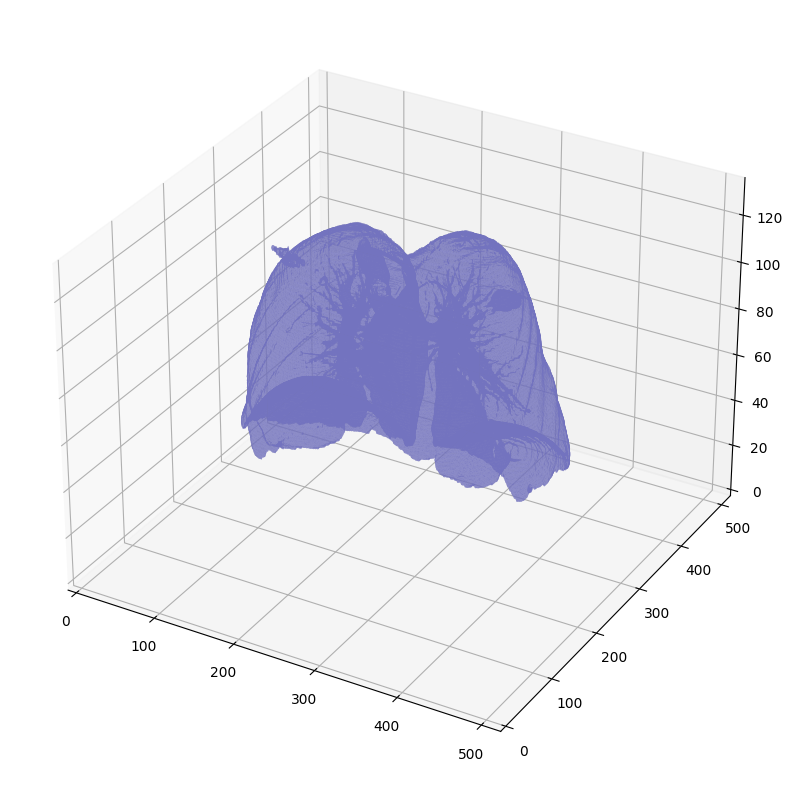

In [5]:
## Plot lungs + solid stuctures

plot_3d_v2(segmented_lungs, 0)

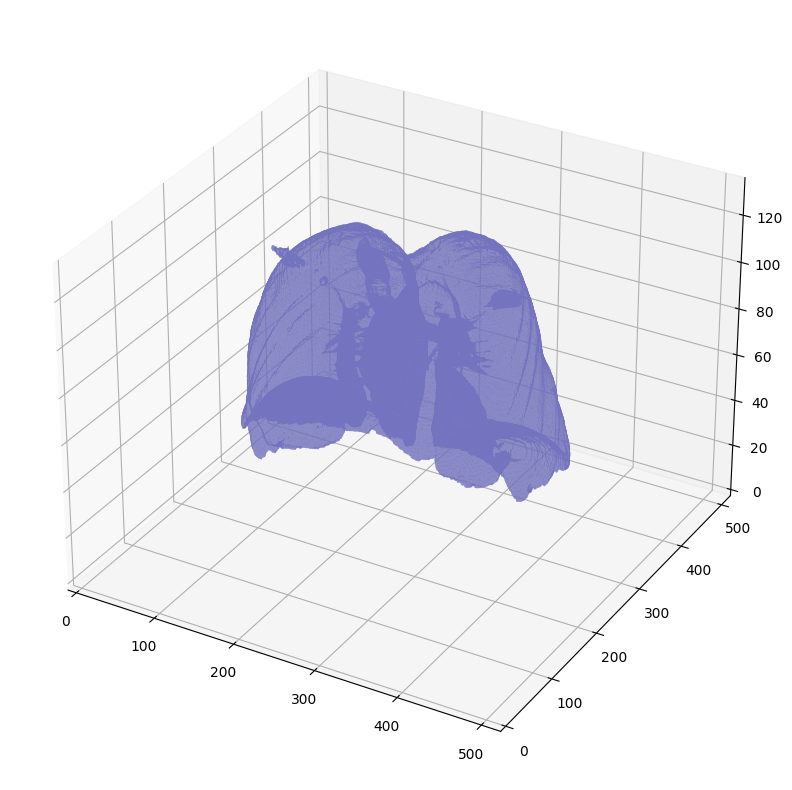

In [6]:
## Plot only the lungs

plot_3d_v2(segmented_lungs_fill, 0)

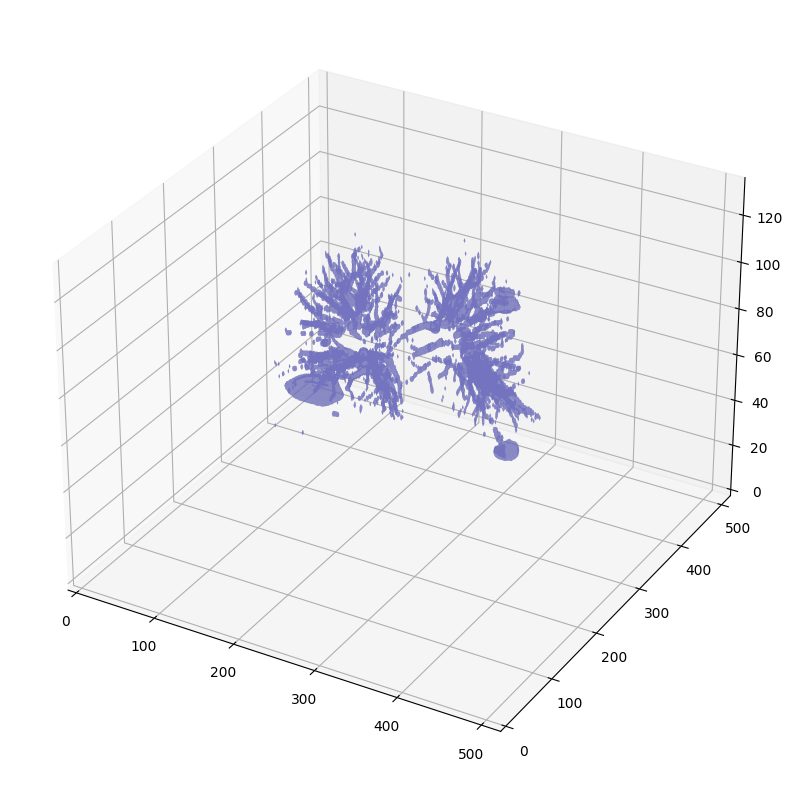

In [7]:
## Plot only the solid stuctures inside the lungs

plot_3d_v2(segmented_lungs_fill - segmented_lungs, 0)

### Here we plot only the segmented lungs from patient 0001. Using HU units we are able to plot solely the air masses (the lungs)

In [8]:
## Normalize Images

lungs_normalized = normalize(segmented_lungs_fill)

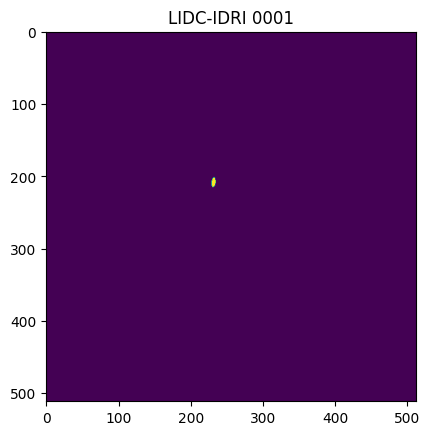

In [9]:
## Show CT scans of the patient (only the lungs) NORMALIZED

for sl in lungs_normalized:
    plt.imshow(sl)
    plt.title("LIDC-IDRI 0001")
    plt.show()
    clear_output(wait=True)


### -Creating image/mask pairs

In [10]:
## Creating nodule images/masks

# Hyper Parameter setting for pylidc
confidence_level = 0.01
padding = 512

totaltime=50000
start_time=time.time()
elapsed_time=0
pidx=1
slicemalignacy=[]

for patient in patients:
    print("Processing patient",patient,"ETA:",(totaltime-elapsed_time)/3600,"hrs")
    pid = patient
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    nodules_annotation = scan.cluster_annotations()
    vol = scan.to_volume()

    patient_mask_dir = Path(MASK_DIR) / pid
    patient_image_dir = Path(IMAGE_DIR) / pid
    Path(patient_mask_dir).mkdir(parents=True, exist_ok=True)
    Path(patient_image_dir).mkdir(parents=True, exist_ok=True)

    # Generate consensus masks for each nodule
    consensus_masks = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        mask, cbbox, masks = consensus(nodule, confidence_level, [(padding, padding), (padding, padding), (0, 0)])
        nodmalignacy = int(nodule[0].malignancy)
        consensus_masks.append((mask, cbbox, nodmalignacy))
        
    total_slices = vol.shape[-1]

    slidx=1
    for slice_index in range(vol.shape[-1]):
        mask_slice = np.zeros_like(vol[:, :, slice_index], dtype=np.uint8)
        nodule_in_slice = False
        reverse_slice_index = total_slices - slice_index

        for mask, cbbox, nodmalignacy in consensus_masks:
            if cbbox[2].start <= slice_index < cbbox[2].stop:
                # If the current slice is within the bounding box of the nodule
                mask_slice |= mask[:, :, slice_index - cbbox[2].start]
                nodule_in_slice = True
                mal=nodmalignacy

        if nodule_in_slice:
            mask_name = "{}_mask_slice{}N".format(pid[-4:], str(reverse_slice_index).zfill(3))
            
            # Convert the mask_slice to SimpleITK object
            mask_sitk = sitk.GetImageFromArray(mask_slice)
            mask_sitk.SetSpacing((1.0, 1.0, 1.0))  # Set the spacing as needed
            mask_sitk.SetOrigin((0.0, 0.0, 0.0))  # Set the origin as needed
            
            
            # Verify if mask has correct label {0,1}
            unique_labels = set(sitk.GetArrayFromImage(mask_sitk).flatten())
            
            if len(unique_labels)==2:
            
                sitk.WriteImage(mask_sitk, str(patient_mask_dir / (mask_name + '.nii.gz')))
                slicemalignacy.append([patient,slidx,mal])
            
                # Extract and save the corresponding slice image
                image_slice = vol[:, :, slice_index]
                image_name = "{}_image_slice{}N".format(pid[-4:], str(reverse_slice_index).zfill(3))
                image_sitk = sitk.GetImageFromArray(image_slice)
                image_sitk.SetSpacing((1.0, 1.0, 1.0))  # Set the spacing as needed
                image_sitk.SetOrigin((0.0, 0.0, 0.0))  # Set the origin as needed
                sitk.WriteImage(image_sitk, str(patient_image_dir / (image_name + '.nii.gz')))
                slidx+=1

    elapsed_time=time.time()-start_time
    totaltime=elapsed_time/(pidx+1)*len(patients)
    pidx+=1

slmal_df = pd.DataFrame(slicemalignacy)
slmal_df = slmal_df.set_axis(['Pid','Sid','Malignancy'], axis=1)
slmal_df.to_csv(mal_csv, index=True)

print("Exctraction complete!! Total time elapsed:",elapsed_time/3600,"hrs")

Processing patient LIDC-IDRI-0001 ETA: 13.88888888888889 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0002 ETA: 1.5032691526412965 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0003 ETA: 2.3127995445772456 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0004 ETA: 2.795604464577304 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0005 ETA: 2.427135183811188 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0006 ETA: 2.193069562823684 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0007 ETA: 2.113979397075517 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0008 ETA: 2.4656821942329405 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0009 ETA: 2.326498817205429 hrs
Loading dicom files ... This may take a moment.
Processing patie

Processing patient LIDC-IDRI-0075 ETA: 2.852429716158796 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0076 ETA: 2.8885412408176223 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0077 ETA: 2.8841439425300206 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0078 ETA: 2.881004998948839 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0079 ETA: 2.9011395949292957 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0080 ETA: 2.878309838945667 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0081 ETA: 2.931253066936965 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0082 ETA: 2.919767919297464 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0083 ETA: 2.9203116184113975 hrs
Loading dicom files ... This may take a moment.
Processing pati

Processing patient LIDC-IDRI-0148 ETA: 2.632649721240138 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0149 ETA: 2.6265875063726565 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0150 ETA: 2.61874878387098 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0151 ETA: 2.6069426219870366 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0152 ETA: 2.592980707141391 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0153 ETA: 2.5799801755618077 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0154 ETA: 2.5731575458940834 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0155 ETA: 2.566937561727339 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0156 ETA: 2.556069583084508 hrs
Loading dicom files ... This may take a moment.
Processing patie

Processing patient LIDC-IDRI-0222 ETA: 2.250965883939474 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0223 ETA: 2.241845365422367 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0224 ETA: 2.2466166524801934 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0225 ETA: 2.23652105682426 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0226 ETA: 2.226422549189602 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0227 ETA: 2.2162421921801463 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0228 ETA: 2.2079888176278994 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0229 ETA: 2.200790071302048 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0230 ETA: 2.2062368301377777 hrs
Loading dicom files ... This may take a moment.
Processing patie

Processing patient LIDC-IDRI-0297 ETA: 1.8592559491017382 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0298 ETA: 1.8617941420962647 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0299 ETA: 1.8706725932767727 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0300 ETA: 1.8751956330653416 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0301 ETA: 1.8834322721781553 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0302 ETA: 1.8849975429645272 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0303 ETA: 1.882928296046015 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0304 ETA: 1.881215039778639 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0305 ETA: 1.877560972274657 hrs
Loading dicom files ... This may take a moment.
Processing pa

Processing patient LIDC-IDRI-0370 ETA: 1.7421659715103477 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0371 ETA: 1.7407920411255984 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0372 ETA: 1.7399524937646407 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0373 ETA: 1.7362994184552412 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0374 ETA: 1.7358020581025821 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0375 ETA: 1.7316330710898107 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0376 ETA: 1.732566354587343 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0377 ETA: 1.734636839993175 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0378 ETA: 1.734409884547471 hrs
Loading dicom files ... This may take a moment.
Processing pa

Processing patient LIDC-IDRI-0444 ETA: 1.6007847940921784 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0445 ETA: 1.5967960588017978 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0446 ETA: 1.5938239938482062 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0447 ETA: 1.5896242513143428 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0448 ETA: 1.5879655052735209 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0449 ETA: 1.587995974919685 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0450 ETA: 1.5831120580054245 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0451 ETA: 1.5853236419771923 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0452 ETA: 1.5814333207250728 hrs
Loading dicom files ... This may take a moment.
Processing 

Processing patient LIDC-IDRI-0519 ETA: 1.4288361791063922 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0520 ETA: 1.4246648795191008 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0521 ETA: 1.4224597250409103 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0522 ETA: 1.4212504440603237 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0523 ETA: 1.4174493282660368 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0524 ETA: 1.4154600050285004 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0525 ETA: 1.4136468881800885 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0526 ETA: 1.412891425991815 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0527 ETA: 1.4112078787064724 hrs
Loading dicom files ... This may take a moment.
Processing 

Processing patient LIDC-IDRI-0595 ETA: 1.2202179458631832 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0596 ETA: 1.2172339638689684 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0597 ETA: 1.2143193974342446 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0598 ETA: 1.2102593263963723 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0599 ETA: 1.2064504842471524 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0600 ETA: 1.2038278295067064 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0601 ETA: 1.1998577070591117 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0602 ETA: 1.2008791956150975 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0603 ETA: 1.1980366884389322 hrs
Loading dicom files ... This may take a moment.
Processing

Processing patient LIDC-IDRI-0669 ETA: 1.0281567252691084 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0670 ETA: 1.02529603704364 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0671 ETA: 1.0214482517840164 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0672 ETA: 1.0197260042268843 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0673 ETA: 1.0171523979437982 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0674 ETA: 1.0157304325258287 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0675 ETA: 1.0130956702433505 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0676 ETA: 1.0091630141364836 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0677 ETA: 1.0065767604922071 hrs
Loading dicom files ... This may take a moment.
Processing p

Processing patient LIDC-IDRI-0744 ETA: 0.8178506790259957 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0745 ETA: 0.8156866284454817 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0746 ETA: 0.8118907147665535 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0747 ETA: 0.8080857347957595 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0748 ETA: 0.804306225212053 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0749 ETA: 0.8010253221825906 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0750 ETA: 0.7984784081452532 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0751 ETA: 0.7951589703854319 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0752 ETA: 0.794269253425245 hrs
Loading dicom files ... This may take a moment.
Processing p

Processing patient LIDC-IDRI-0818 ETA: 0.5933904134514609 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0819 ETA: 0.5898479930756776 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0820 ETA: 0.5881216070801626 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0821 ETA: 0.5848925829947746 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0822 ETA: 0.5819972501117687 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0823 ETA: 0.5792147560321458 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0824 ETA: 0.5756467666040079 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0825 ETA: 0.5720604393247878 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0826 ETA: 0.5688084648535091 hrs
Loading dicom files ... This may take a moment.
Processing

Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0891 ETA: 0.3712219908360824 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0892 ETA: 0.36782969843582225 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0893 ETA: 0.3649423334795958 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0894 ETA: 0.36232124298588236 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0895 ETA: 0.3592326713309174 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0896 ETA: 0.3562670327332257 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0897 ETA: 0.35308451292272114 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0898 ETA: 0.3499366126480027 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0899 ETA: 0.34679221504685254 hrs
Loadin

Processing patient LIDC-IDRI-0964 ETA: 0.14643738017673716 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0965 ETA: 0.143269716271056 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0966 ETA: 0.14030202399989067 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0967 ETA: 0.1372013176908149 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0968 ETA: 0.13404061525943536 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0969 ETA: 0.13113176178277425 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0970 ETA: 0.12803258043388066 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0971 ETA: 0.12488711107366321 hrs
Loading dicom files ... This may take a moment.
Processing patient LIDC-IDRI-0972 ETA: 0.12177531383291555 hrs
Loading dicom files ... This may take a moment.
Proc

### -Extracting features from the images/masks

In [11]:
# Initialize the PyRadiomics feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor(config, shape2D=True)

# Create an empty list to store the feature vectors
all_features = []
errors = []  # So we can later remove entries from the malignancy dataset

# Iterate through each patient
for patient in patients:
    print("Processing patient", patient)
    image_files = sorted(list((Path(IMAGE_DIR) / patient).glob("*.nii.gz")))
    mask_files = sorted(list((Path(MASK_DIR) / patient).glob("*.nii.gz")))
    
    slidx = 1
    for image_file, mask_file in zip(image_files, mask_files):
        try:
            # Load the image and mask using SimpleITK
            image = sitk.ReadImage(str(image_file))
            mask = sitk.ReadImage(str(mask_file))
            unique_labels = set(sitk.GetArrayFromImage(mask).flatten())

            # Extract features using PyRadiomics
            feature_vector = extractor.execute(image, mask, label=1)

            # Append the feature vector to the list
            all_features.append(feature_vector)
        except ValueError as e:
            # Handle the exception
            print(f"Error processing patient {patient}, slice {slidx}: {e}")
            errors.append((patient, slidx))
        
        slidx += 1

Processing patient LIDC-IDRI-0001


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0002


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0003


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0004


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0005


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0006


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0007


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0008


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0009


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0010


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0011


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0011, slice 7: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0011, slice 13: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0012


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0013


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0014


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0015


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0016


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0017


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0018


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0019


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0020


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0021


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0022


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0023


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0024


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0025


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0026


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0027


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0027, slice 2: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0028
Processing patient LIDC-IDRI-0029


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0030


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0031


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0032
Processing patient LIDC-IDRI-0033


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0034


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0035


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0036


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0037


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0038


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0039


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0039, slice 8: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0040


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0041


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0042


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0043


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0044


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0045


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0046


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0047


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0048


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0049


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0050


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0051


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0052


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0053


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0054


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0055


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0056


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0057


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0058


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0059


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0060


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0061


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0062
Processing patient LIDC-IDRI-0063


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0064


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0065


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0066


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0067


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0068


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0069


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0070


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0071
Processing patient LIDC-IDRI-0072


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0073


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0074


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0075


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0076


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0077


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0078


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0079


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0080


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0081


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0082


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0083


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0083, slice 5: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0084


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0085


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0086


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0087


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0088


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0089


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0090


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0091


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0092


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0093


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0094


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0095


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0096


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
C:\Users\Daniel\anaconda3\envs\LIDC-IDRI\lib\site-packages\radiomics\glcm.py:258: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(ac, 1)
C:\Users\Daniel\anaconda3\envs\LIDC-IDRI\lib\site-packages\radiomics\glcm.py:276: RuntimeWarning: Mean of empty slice.
  return self.coefficients['ux'].mean((1, 2, 3))
C:\Users\Daniel\anaconda3\envs\LIDC-IDRI\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Daniel\anaconda3\envs\LIDC-IDRI\lib\site-packages\radiomics\glcm.py:294: RuntimeWarning: Mean of empty slice
  return numpy.nanmean(cp, 1)
C:\Users\Daniel\anaconda3\envs\LIDC-IDRI\lib\site-packages\radiomics\glcm.py:312: RuntimeWarning: Mean of empty 

Processing patient LIDC-IDRI-0097


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0098


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0099


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0100
Processing patient LIDC-IDRI-0101


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0102


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0103


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0104


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0105


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0106


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0107


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0108


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0109


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0110


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0111


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0112


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0113


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0114


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0115


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0116


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0117


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0118


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0119


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0120


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0121


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0122


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0123


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0124


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0124, slice 20: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0125


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0126


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0127


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0128


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0129


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0130


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0131


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0131, slice 5: mask has too few dimensions (number of dimensions 1, minimum required 2)
Error processing patient LIDC-IDRI-0131, slice 6: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0132


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0133


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0134


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0135


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0136


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0137


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0138


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0139


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0140


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0141


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0142


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0142, slice 23: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0143
Processing patient LIDC-IDRI-0144


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0145


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0146


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0147


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0148


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0149


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0150


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0151


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0152


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0153


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0154


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0155


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0156


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0157
Error processing patient LIDC-IDRI-0157, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0158


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0159


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0160


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0161


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0162


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0163


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0164


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0164, slice 13: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0165


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0166


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0167


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0168


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0169


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0170


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0171


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0171, slice 6: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0172


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0173


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0174
Processing patient LIDC-IDRI-0175


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0176


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0177


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0178


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0179


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0180


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0181


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0182


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0183


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0184


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0185


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0186


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0187


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0188


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0189
Processing patient LIDC-IDRI-0190


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0191


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0192


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0193


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0194


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0195


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0196


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0197
Processing patient LIDC-IDRI-0198


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0199


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0199, slice 19: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0200


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0201


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0202


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0203


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0204


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0205
Processing patient LIDC-IDRI-0206


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0207


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0208


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0209


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0210


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0211


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0212


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0213


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0214
Processing patient LIDC-IDRI-0215


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0216


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0217


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0218
Processing patient LIDC-IDRI-0219


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0220


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0221


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0222


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0223


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0224
Processing patient LIDC-IDRI-0225
Processing patient LIDC-IDRI-0226
Processing patient LIDC-IDRI-0227


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0228


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0229


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0230


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0231


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0232


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0233


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0234


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0235


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0236


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0237


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0239
Processing patient LIDC-IDRI-0240


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0241


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0242


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0243


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0244


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0245


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0246


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0247
Processing patient LIDC-IDRI-0248


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0249


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0250


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0251


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0252


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0253
Processing patient LIDC-IDRI-0254


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0255


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0256


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0257


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0257, slice 6: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0258


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0259


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0260


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0261
Processing patient LIDC-IDRI-0262


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0263


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0264


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0265


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0266


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0267


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0268


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0269


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0270


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0271


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0272


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0273


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0274


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0275


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0276


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0277


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0278


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0279
Processing patient LIDC-IDRI-0280


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0281


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0282


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0283


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0283, slice 5: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0284


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0285


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0286


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0287


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0288


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0289


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0290


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0291


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0292


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0293
Processing patient LIDC-IDRI-0294


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0295
Processing patient LIDC-IDRI-0296


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0297


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0298


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0299


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0300


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0301


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0302


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0303


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0304


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0305
Error processing patient LIDC-IDRI-0305, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0306
Processing patient LIDC-IDRI-0307
Processing patient LIDC-IDRI-0308


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0309


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0310


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0311


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0312


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0313


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0314


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0315


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0315, slice 21: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0316
Processing patient LIDC-IDRI-0317


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0318


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0319


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0319, slice 6: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0320


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0321


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0322
Processing patient LIDC-IDRI-0323


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0324


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0325


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0326


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0327
Processing patient LIDC-IDRI-0328


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0329


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0330
Processing patient LIDC-IDRI-0331
Processing patient LIDC-IDRI-0332


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0333
Processing patient LIDC-IDRI-0334


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0335


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0336
Processing patient LIDC-IDRI-0337
Error processing patient LIDC-IDRI-0337, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0338
Error processing patient LIDC-IDRI-0338, slice 1: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0339


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0340


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0341


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0342
Processing patient LIDC-IDRI-0343


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0344


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0345


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0346


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0347


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0348


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0349
Processing patient LIDC-IDRI-0350


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0351


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0352


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0353


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0354


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0355


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0356


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0357


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0358


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0359


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0360


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0360, slice 31: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0361
Processing patient LIDC-IDRI-0362


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0363


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0364
Processing patient LIDC-IDRI-0365


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0366


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0367
Error processing patient LIDC-IDRI-0367, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0368


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0369


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0370


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0371


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0372


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0373


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0374


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0375
Error processing patient LIDC-IDRI-0375, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0376


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0377


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0378


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0379


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0380


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0381


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0382
Processing patient LIDC-IDRI-0383
Processing patient LIDC-IDRI-0384


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0385


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0385, slice 45: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0386


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0386, slice 8: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0386, slice 44: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0387


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0388


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0389
Processing patient LIDC-IDRI-0390


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0390, slice 11: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0391
Processing patient LIDC-IDRI-0392


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0393


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0394


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0395


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0396


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0397


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0398


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0399


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0400


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0401
Processing patient LIDC-IDRI-0402


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0403


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0404


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0404, slice 7: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0405


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0405, slice 19: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0406


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0407


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0408


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0409


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0410
Processing patient LIDC-IDRI-0411


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0412


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0413


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0414


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0415


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0416


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0417
Processing patient LIDC-IDRI-0418
Processing patient LIDC-IDRI-0419


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0419, slice 5: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0420


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0421


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0422
Processing patient LIDC-IDRI-0423


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0424


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0425
Processing patient LIDC-IDRI-0426


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0427


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0428
Processing patient LIDC-IDRI-0429


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0430


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0430, slice 10: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0431


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0432


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0433


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0434


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0435


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0435, slice 7: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0436


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0437


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0437, slice 16: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0437, slice 33: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0438


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0439


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0440


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0441
Processing patient LIDC-IDRI-0442


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0443


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0444


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0445


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0446
Processing patient LIDC-IDRI-0447


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0448


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0449


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0450


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0451


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0452


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0453


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0454


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0454, slice 23: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0454, slice 34: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0455
Processing patient LIDC-IDRI-0456


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0457


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0458


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0459


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0459, slice 15: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0460


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0461


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0462


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0463


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0464


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0465
Processing patient LIDC-IDRI-0466


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0467


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0468


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0469


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0470


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0471


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0472
Processing patient LIDC-IDRI-0473


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0474


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0474, slice 12: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0475


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0476


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0477


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0478


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0479


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0479, slice 12: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0480


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0481


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0482
Processing patient LIDC-IDRI-0483


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0484


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0485


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0486


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0486, slice 8: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0487


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0487, slice 51: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0488


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0489


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0490


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0491


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0491, slice 5: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0491, slice 49: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0492


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0493


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0494
Error processing patient LIDC-IDRI-0494, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0495


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0496


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0497


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0498


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0499


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0500


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0501


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0502


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0503


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0504


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0505


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0506
Processing patient LIDC-IDRI-0507


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0508


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0509


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0510


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0511
Processing patient LIDC-IDRI-0512
Processing patient LIDC-IDRI-0513
Processing patient LIDC-IDRI-0514
Processing patient LIDC-IDRI-0515


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0516


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0517


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0518


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0519
Processing patient LIDC-IDRI-0520


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0521


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0522


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0523


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0524


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0525


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0526


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0527


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0528
Processing patient LIDC-IDRI-0529


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0530


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0531
Processing patient LIDC-IDRI-0532


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0533


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0534


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0535


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0535, slice 3: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0535, slice 6: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0536
Processing patient LIDC-IDRI-0537


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0538


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0539


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0540
Processing patient LIDC-IDRI-0541


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0542


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0543


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0544
Processing patient LIDC-IDRI-0545


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0546


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0547


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0548
Processing patient LIDC-IDRI-0549


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0549, slice 12: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0550


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0551


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0552


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0553


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0554


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0555


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0556


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0557


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0558


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0559


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0560


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0561
Processing patient LIDC-IDRI-0562


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0563


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0564
Processing patient LIDC-IDRI-0565


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0565, slice 19: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0566


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0567


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0568


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0569


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0570


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0571


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0572


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0573
Processing patient LIDC-IDRI-0574


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0575


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0576


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0577


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0578


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0579


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0580
Error processing patient LIDC-IDRI-0580, slice 1: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0581


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0582


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0583


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0584


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0586


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0587


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0588


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0589
Processing patient LIDC-IDRI-0590


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0591


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0592


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0593


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0594


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0595


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0596


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0596, slice 8: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0597


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0598


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0598, slice 4: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0599


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0600
Processing patient LIDC-IDRI-0601


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0602


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0603
Processing patient LIDC-IDRI-0604
Error processing patient LIDC-IDRI-0604, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0605


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0606


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0607


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0608


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0609


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0610


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0611


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0612
Processing patient LIDC-IDRI-0613


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0614


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0615


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0615, slice 8: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0616
Processing patient LIDC-IDRI-0617


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0618


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0619


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0620


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0621


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0622
Processing patient LIDC-IDRI-0623
Processing patient LIDC-IDRI-0624
Error processing patient LIDC-IDRI-0624, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0624, slice 9: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0624, slice 64: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0624, slice 69: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0625


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0626
Processing patient LIDC-IDRI-0627
Processing patient LIDC-IDRI-0628


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0629


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0630


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0631


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0632
Processing patient LIDC-IDRI-0633


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0634


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0635


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0636


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0636, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0636, slice 14: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0637


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0637, slice 13: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0637, slice 29: mask has too few dimensions (number of dimensions 1, minimum required 2)
Error processing patient LIDC-IDRI-0637, slice 30: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0638


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0639


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0640


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0641
Error processing patient LIDC-IDRI-0641, slice 1: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0642


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0643


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0644


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0645


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0646
Processing patient LIDC-IDRI-0647


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0648


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0649


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0650


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0651


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0652


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0653
Processing patient LIDC-IDRI-0654


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0655


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0656


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0657


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0658


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0659


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0660


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0661


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0662


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0663


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0664


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0665
Processing patient LIDC-IDRI-0666


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0667
Processing patient LIDC-IDRI-0668
Processing patient LIDC-IDRI-0669
Error processing patient LIDC-IDRI-0669, slice 1: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0670


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0671


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0672


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0673


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0674


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0675
Processing patient LIDC-IDRI-0676


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0677


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0678


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0679
Processing patient LIDC-IDRI-0680


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0681


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0682


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0683
Processing patient LIDC-IDRI-0684


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0685
Processing patient LIDC-IDRI-0686


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0687


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0688


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0689
Processing patient LIDC-IDRI-0690
Processing patient LIDC-IDRI-0691
Processing patient LIDC-IDRI-0692


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0693


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0694


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0695


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0696


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0697


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0698


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0699


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0700


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0701


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0702


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0702, slice 11: mask has too few dimensions (number of dimensions 1, minimum required 2)
Error processing patient LIDC-IDRI-0702, slice 12: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0703


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0703, slice 42: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0704


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0705


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0706


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0707


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0708


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0709


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0710
Processing patient LIDC-IDRI-0711
Processing patient LIDC-IDRI-0712


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0713


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0714


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0715


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0716
Processing patient LIDC-IDRI-0717
Error processing patient LIDC-IDRI-0717, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0717, slice 5: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0718
Processing patient LIDC-IDRI-0719


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0720


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0721


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0722


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0723


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0724


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0725


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0726


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0726, slice 10: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0726, slice 14: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0727


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0728


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0729


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0730


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0730, slice 5: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0731
Processing patient LIDC-IDRI-0732


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0733


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0733, slice 7: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0733, slice 19: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0733, slice 27: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0734


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0735


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0736


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0737
Processing patient LIDC-IDRI-0738
Processing patient LIDC-IDRI-0739


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0740


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0741


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0742


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0742, slice 33: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0743


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0744


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0745
Processing patient LIDC-IDRI-0746
Processing patient LIDC-IDRI-0747


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0748


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0749


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0750


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0751


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0752


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0753


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0754


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0755
Processing patient LIDC-IDRI-0756


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0757


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0758


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0759


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0759, slice 3: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Error processing patient LIDC-IDRI-0759, slice 4: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0759, slice 5: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0759, slice 12: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0760
Processing patient LIDC-IDRI-0761


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0762


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0763


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0763, slice 6: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0764
Processing patient LIDC-IDRI-0765


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0766


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0767
Processing patient LIDC-IDRI-0768


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0769


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0770


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0770, slice 21: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0771


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0772


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0773


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0773, slice 14: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0774
Processing patient LIDC-IDRI-0775


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0776


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0777


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0778


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0779


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0780


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0781


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0782


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0783


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0784
Processing patient LIDC-IDRI-0785


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0786


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0787


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0787, slice 5: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0788


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0789


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0789, slice 6: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0790


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0791


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0792


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0793


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0794


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0795


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0796


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0797


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0798


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0799


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0800


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0801


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0801, slice 21: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0802


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0803


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0804
Processing patient LIDC-IDRI-0805


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0806


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0806, slice 8: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0806, slice 13: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0807


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0808
Processing patient LIDC-IDRI-0809
Error processing patient LIDC-IDRI-0809, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0810


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0811


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0812


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0813


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0814


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0814, slice 12: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0815


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0816


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0816, slice 10: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0817


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0818


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0819


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0820


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0821


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0822


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0823


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0824


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0825


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0826


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0827


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0827, slice 24: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0827, slice 34: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0828


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0829


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0830


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0831


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0832


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0833


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0834


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0835


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0836


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0837


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0838


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0839
Processing patient LIDC-IDRI-0840


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0841
Processing patient LIDC-IDRI-0842
Error processing patient LIDC-IDRI-0842, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0843


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0844


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0844, slice 38: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0845


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0845, slice 6: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Error processing patient LIDC-IDRI-0845, slice 7: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0845, slice 21: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0846


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0847


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0848


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0849


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0849, slice 42: mask has too few dimensions (number of dimensions 1, minimum required 2)
Error processing patient LIDC-IDRI-0849, slice 43: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0849, slice 55: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0850


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0851


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0852


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0853
Processing patient LIDC-IDRI-0854


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0855


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0855, slice 32: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0856


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0857
Error processing patient LIDC-IDRI-0857, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0857, slice 5: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0858


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0859


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0860


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0861


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0862
Processing patient LIDC-IDRI-0863
Error processing patient LIDC-IDRI-0863, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0864


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0865


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0866


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0867


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0868


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0869


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0870


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0871


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0872


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0873


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0874


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0875
Error processing patient LIDC-IDRI-0875, slice 1: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0875, slice 2: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0876
Processing patient LIDC-IDRI-0877
Processing patient LIDC-IDRI-0878
Processing patient LIDC-IDRI-0879


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0880


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0881
Processing patient LIDC-IDRI-0882


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0883


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0884


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0885
Processing patient LIDC-IDRI-0886


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0887
Processing patient LIDC-IDRI-0888


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0889
Processing patient LIDC-IDRI-0890


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0891
Processing patient LIDC-IDRI-0892


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0893


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0894


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0895
Error processing patient LIDC-IDRI-0895, slice 1: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0895, slice 9: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0896


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0897
Processing patient LIDC-IDRI-0898


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0899


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0899, slice 3: mask has too few dimensions (number of dimensions 1, minimum required 2)
Processing patient LIDC-IDRI-0900
Processing patient LIDC-IDRI-0901
Processing patient LIDC-IDRI-0902


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0903
Processing patient LIDC-IDRI-0904


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0905


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0906


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0907


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0908


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0909


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0910


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0911


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0912


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0913


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0914


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0915


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0916
Error processing patient LIDC-IDRI-0916, slice 1: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0917


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0918
Processing patient LIDC-IDRI-0919


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0920


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0921


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0922


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0923


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0924


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0925


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0926


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0927
Processing patient LIDC-IDRI-0928


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0929


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0930
Processing patient LIDC-IDRI-0931
Processing patient LIDC-IDRI-0932


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0933


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0934
Processing patient LIDC-IDRI-0935


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0936


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0937
Processing patient LIDC-IDRI-0938


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0939


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0940


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0941


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0942


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0943


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0944


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0945


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0946


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0947


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0947, slice 23: mask has too few dimensions (number of dimensions 1, minimum required 2)
Error processing patient LIDC-IDRI-0947, slice 24: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-0947, slice 25: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0947, slice 42: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0948
Processing patient LIDC-IDRI-0949


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0950


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0951


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0952
Processing patient LIDC-IDRI-0953


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0954
Processing patient LIDC-IDRI-0955


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0956


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0957


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0958


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0959


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0960
Processing patient LIDC-IDRI-0961


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0962


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0963
Error processing patient LIDC-IDRI-0963, slice 1: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0964
Processing patient LIDC-IDRI-0965


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0966


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0967
Processing patient LIDC-IDRI-0968


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0969


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0970
Processing patient LIDC-IDRI-0971


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0972


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0973


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0974


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0975
Processing patient LIDC-IDRI-0976


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0977


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0978


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0979
Processing patient LIDC-IDRI-0980


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0981


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0982


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Error processing patient LIDC-IDRI-0982, slice 38: mask only contains 1 segmented voxel! Cannot extract features for a single voxel.
Processing patient LIDC-IDRI-0983


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0984


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0985


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0986


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0987


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0988
Processing patient LIDC-IDRI-0989


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0990


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0991


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0992
Processing patient LIDC-IDRI-0993


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0994


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0995
Processing patient LIDC-IDRI-0996


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-0997


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0998


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-0999


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1000


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Error processing patient LIDC-IDRI-1000, slice 9: mask has too few dimensions (number of dimensions 1, minimum required 2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-1001


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-1002


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1003


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1004


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1005


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1006


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-1007


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1008


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1009


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1010


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


Processing patient LIDC-IDRI-1011


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input 

Processing patient LIDC-IDRI-1012


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input


### Here we can see the dataset that was extracted. Each entry corresponds to a image/mask pair. All of these pairs contain nodule

In [21]:
# Create a DataFrame with extracted features and metadata as well as malignacy label
features_df = pd.DataFrame(all_features)
features_df

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis
0,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},cc11abdb1c12c995e469b21742fc39b7576913ee,2D,"(1.0, 1.0)",...,5.695652173913044,32.68289224952741,165.93478260869566,3.0869565217391304,433.9130434782609,0.06678547158239319,0.028086961177302895,0.6480978260869565,115.55932971014491,0.021695288053967296
1,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},92ec72b8bdba4bbef119eeb30821cd83be1fc509,2D,"(1.0, 1.0)",...,19.793984962406014,99.65624738538074,564.7233082706767,4.109774436090226,2857.1233082706767,0.02525172707641441,0.00869734236281599,0.5543028404344194,277.89646031746037,0.0057162789898808075
2,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7848b1014cc7dcdbdbb5388fb51a3eb169481104,2D,"(1.0, 1.0)",...,39.279946164199195,91.34886577097323,952.056527590848,10.351278600269179,13380.982503364738,0.014637135378462457,0.006147277113680608,0.43958434745963587,296.4278939563837,0.0053500196055449945
3,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},69e585facef3398ffbff7803afad6aa0025c1067,2D,"(1.0, 1.0)",...,76.31487889273356,64.49563582811508,826.3702422145328,12.790080738177624,13060.520184544406,0.01818657162703605,0.004796149487491694,0.3906593067510228,230.74083279154075,0.0038173449286251575
4,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},a41a6e99ffcc32a5335863bcf44158c40b282210,2D,"(1.0, 1.0)",...,88.56818181818181,67.79658898811556,1127.60847107438,12.394628099173554,16899.86673553719,0.011890608573897251,0.0030941520474749803,0.374834427199484,308.1000064244017,0.0024905243142700688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14353,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},ca35a7c36bc5d112bde46288344024a3226e2a32,2D,"(1.0, 1.0)",...,21.0,15.25175733589093,83.73170731707317,6.909407665505227,516.9372822299651,0.24171610939294372,0.038189190443449365,0.3566860240030972,32.394325396825394,0.01599833692499002
14354,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},67b0db0f83600f1a3919f003521c5af7c5c46db8,2D,"(1.0, 1.0)",...,3.682926829268293,17.34205829863177,84.90243902439025,2.8536585365853657,231.8780487804878,0.09240316206085056,0.05928145549656267,0.6720867208672087,58.67344173441735,0.05276275557769621
14355,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},a3bd42c61c83ef47a882705fbe6e1397c8bd162a,2D,"(1.0, 1.0)",...,4.269230769230769,57.99768860946746,328.66346153846155,2.3076923076923075,858.3942307692307,0.02584630561002954,0.019480600262086336,0.7264957264957265,215.3653846153846,0.01815839993704186
14356,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d264d077aef4f0ae56ced46f2af9dd02d38b01c3,2D,"(1.0, 1.0)",...,4.195121951219512,43.11897679952409,220.46341463414635,2.731707317073171,953.0243902439024,0.050205621487054604,0.041936667876023855,0

### -Cleaning and merging datasets

In [22]:
# Clearing malignancy dataset and merging with features dataset

'''
In the code above (feature extraction) we do not save the features for the slices that trow an error.
That means that we will get less entries on the features dataset compared to the malignacy dataset.
So we need to erase the error entries from the maligancy dataset to be able to correctly merge the datasets later.
'''
feat=features_df
mal=slmal_df

for error in errors:
    pid, sl = error
    i = mal[((mal['Pid'] == pid) &(mal['Sid'] == sl))].index
    mal=mal.drop(i)

# Reset the index to eliminate missing values
mal = mal.reset_index(drop=True)

# Merge datasets
feat = pd.merge(feat, mal, left_index=True, right_index=True)
feat.to_csv(features_csv, index=True)
feat

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,Pid,Sid,Malignancy
0,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},cc11abdb1c12c995e469b21742fc39b7576913ee,2D,"(1.0, 1.0)",...,3.0869565217391304,433.9130434782609,0.06678547158239319,0.028086961177302895,0.6480978260869565,115.55932971014491,0.021695288053967296,LIDC-IDRI-0001,1,5
1,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},92ec72b8bdba4bbef119eeb30821cd83be1fc509,2D,"(1.0, 1.0)",...,4.109774436090226,2857.1233082706767,0.02525172707641441,0.00869734236281599,0.5543028404344194,277.89646031746037,0.0057162789898808075,LIDC-IDRI-0001,2,5
2,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},7848b1014cc7dcdbdbb5388fb51a3eb169481104,2D,"(1.0, 1.0)",...,10.351278600269179,13380.982503364738,0.014637135378462457,0.006147277113680608,0.43958434745963587,296.4278939563837,0.0053500196055449945,LIDC-IDRI-0001,3,5
3,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},69e585facef3398ffbff7803afad6aa0025c1067,2D,"(1.0, 1.0)",...,12.790080738177624,13060.520184544406,0.01818657162703605,0.004796149487491694,0.3906593067510228,230.74083279154075,0.0038173449286251575,LIDC-IDRI-0001,4,5
4,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},a41a6e99ffcc32a5335863bcf44158c40b282210,2D,"(1.0, 1.0)",...,12.394628099173554,16899.86673553719,0.011890608573897251,0.0030941520474749803,0.374834427199484,308.1000064244017,0.0024905243142700688,LIDC-IDRI-0001,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14353,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},ca35a7c36bc5d112bde46288344024a3226e2a32,2D,"(1.0, 1.0)",...,6.909407665505227,516.9372822299651,0.24171610939294372,0.038189190443449365,0.3566860240030972,32.394325396825394,0.01599833692499002,LIDC-IDRI-1011,23,2
14354,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},67b0db0f83600f1a3919f003521c5af7c5c46db8,2D,"(1.0, 1.0)",...,2.8536585365853657,231.8780487804878,0.09240316206085056,0.05928145549656267,0.6720867208672087,58.67344173441735,0.05276275557769621,LIDC-IDRI-1012,1,2
14355,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},a3bd42c61c83ef47a882705fbe6e1397c8bd162a,2D,"(1.0, 1.0)",...,2.3076923076923075,858.3942307692307,0.02584630561002954,0.019480600262086336,0.7264957264957265,215.3653846153846,0.01815839993704186,LIDC-IDRI-1012,2,2
14356,v3.1.0,1.23.5,2.1.1,1.4.1,3.9.18,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d264d077aef4f0ae56ced46f2af9dd02d38b01c3,2D,"(1.0, 1.0)",...,2.731707317073171,953.0243902439024,0.050205621487054604,0.041936667876023855,0.7313685636856369,133.91023035230353,0.04015669234589489,LIDC-IDRI-1012,3,2


### Now we have a dataset ready for further work. For each entry there is a malignancy level as label (got from pylidc, not actual the "real" value)